In [34]:
import pandas as pd
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torchvision import models
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from typing_extensions import dataclass_transform
import random

torch.manual_seed(42)
np.random.seed(42)

In [35]:
class SkinData:
  def __init__(self, root, transform = True, train = True):
      if train:
        data_folder = 'balanced_dataset/'

      else:
        data_folder = 'Validation_Image/'

      data_dirs = os.listdir(os.path.join(root,data_folder))
      self.data_files = []
      self.labels = []
      label = 0
      for dir in data_dirs:
        path_name = os.path.join(root,data_folder,dir)
        data_samples = [os.path.join(path_name, fname) for fname in os.listdir(path_name)]
        label_samples = label * np.ones(len(data_samples))
        print(dir)
        print(len(label_samples))
        self.data_files.extend(data_samples)
        self.labels.extend(label_samples)
        self.transform = transform

        label += 1

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, index):
    new_width = 256
    new_height = 256
    data_file = self.data_files[index]
    image = np.array(cv2.imread(data_file))
    label = np.array(self.labels[index])

    data_sample = cv2.resize(image, (new_width, new_height))
    resize_data = np.array(data_sample)

    if self.transform:
      data_sample = torch.from_numpy(data_sample)
      lable = torch.from_numpy(label)

    data_point = {'data_sample': data_sample, 'lable':lable}

    return data_point

In [36]:
root = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer'
dataset = SkinData(root, transform=True, train= True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loder = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loder = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_dataset = SkinData(root, transform=True, train = False)

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

akiec
1244
bcc
1464
bkl
1044
df
1308
mel
1057
nv
1302
vasc
1350
akiec
16
bcc
26
bkl
55
df
6
mel
56
nv
335
vasc
7


In [37]:
len(train_dataset)

7015

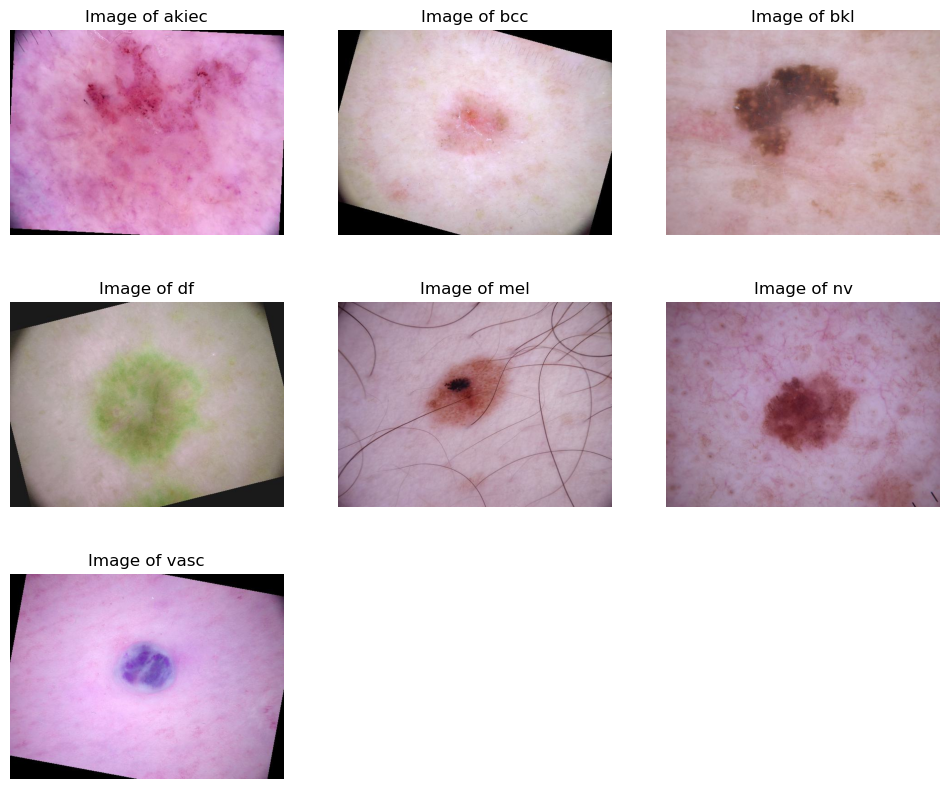

In [25]:
# Data Visualization
# Define the directory path for the training images
train_images_dir = r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Balanced_dataset"

top_n = 20  # Variable for top-n random images to select from.
image_sample = []  # List containing array of images.
image_sample_category = []  # List containing image type

# Make sure train_images_dir is correctly defined before this loop
for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = []  # List of top n images from current sub-dir.

    # Ensure we handle cases where there are fewer than top_n images
    num_images = min(len(images_paths), top_n)

    # Appending up to top_n images from the current sub-dir
    for image_path in images_paths[:num_images]:
        current_dir_img_paths.append(image_path)

    # Select a random image from the current directory
    if current_dir_img_paths:
        selected_image = random.choice(current_dir_img_paths)  # Selecting random image from the list
        image = cv2.imread(selected_image)  # Reading the image

        if image is not None:
            image = image[:, :, ::-1]  # Converting BGR to RGB
            image_sample_category.append(sub_dir.name)  # Append image category (cancer type)
            image_sample.append(image)  # Append the image array to the list
        else:
            print(f"Warning: Could not read image {selected_image}")
    else:
        print(f"No images found in directory {sub_dir.name}")

# Plotting the selected random images
plt.figure(figsize=(12, 10))
for num in range(len(image_sample)):
    plt.subplot(3, 3, num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}")
    plt.imshow(image_sample[num])

plt.show()

tensor(0., dtype=torch.float64)


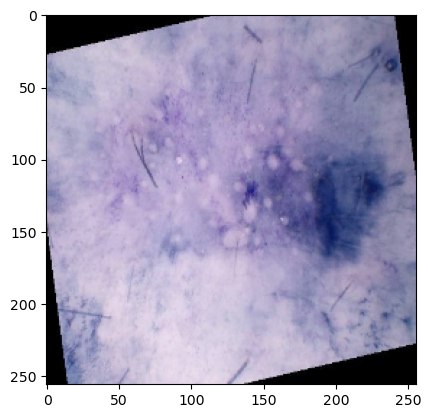

In [38]:
plt.imshow(train_dataset[1000]['data_sample'])
print(train_dataset[1000]['lable'])

In [39]:
train_dataset[1000]['data_sample'].shape

torch.Size([256, 256, 3])

In [40]:
# Train Accuracy: 73.26%, Validation Accuracy: 64.56%
import torch
import torch.nn as nn

class ImprovedCNNNet(nn.Module):
    def __init__(self):
        super(ImprovedCNNNet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512
            
            nn.Flatten(),  # Flatten the 8x8x512 to a vector
            nn.Linear(8 * 8 * 512, 1024, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 128, bias=True),
            nn.ReLU(True),
            nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        out = self.main(x)
        return out

In [239]:
# class ImprovedCNNNet(nn.Module):
#     def __init__(self):
#         super(ImprovedCNNNet, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512

#             nn.Flatten(),  # Flatten the 8x8x512 to a vector
#             nn.Linear(8 * 8 * 512, 1024, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),  # Dropout to reduce overfitting
#             nn.Linear(1024, 512, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Linear(512, 128, bias=True),
#             nn.ReLU(True),
#             nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x):
#         out = self.main(x)
#         return out

In [240]:
# # Model definition (from previous artifact)
# class ResNetSkinCancer(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNetSkinCancer, self).__init__()
#         self.resnet = models.resnet50(pretrained=True)
#         for param in list(self.resnet.parameters())[:-30]:
#             param.requires_grad = False
#         num_features = self.resnet.fc.in_features
#         self.classifier = nn.Sequential(
#             nn.Linear(num_features, 2048),
#             nn.BatchNorm1d(2048),
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Linear(2048, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(True),
#             nn.Dropout(0.4),
#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(True),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(True),
#             nn.Dropout(0.2),
#             nn.Linear(256, num_classes),
#             nn.LogSoftmax(dim=1)
#         )
#         self.resnet.fc = self.classifier

#     def forward(self, x):
#         return self.resnet(x)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [42]:
net = ImprovedCNNNet().to(device)

In [43]:
print(torch.cuda.get_device_name(0))  # To check your GPU device name
print(torch.cuda.is_available())  # To confirm GPU is available

NVIDIA GeForce RTX 3050 Laptop GPU
True


In [44]:
import torch.optim as optim
# Print the network architecture
print(net)
# Optimizer: Adamax
optimizer = optim.Adamax(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Loss function

# Example: Suppose you have 7 classes with these sample counts
class_counts = torch.tensor([1244, 1464, 1044, 1308, 1057, 1302, 1350], dtype=torch.float32)

# Compute weights (inverse of class frequencies)
class_weights = 1.0 / class_counts  
class_weights /= class_weights.sum()  # Normalize to sum to 1

# Move weights to device (if using GPU)
class_weights = class_weights.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

ImprovedCNNNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(2

In [45]:
len(dataloader_train)

439

In [46]:
# Lists to store average losses and accuracies per epoch
avg_train_loss_list = []
avg_val_loss_list = []
train_acc_list = []
val_acc_list = []

# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer,filename=checkpoint_path)

# Training Loop
for epoch in range(start_epoch,start_epoch+20):  # Now starts from the saved epoch
    accuracy = 0
    val_accuracy = 0
    running_loss = 0.0
    val_running_loss = 0.0
    num_batches_train = len(dataloader_train)
    num_batches_val = len(dataloader_val)

    # Training loop
    for i, data in enumerate(dataloader_train, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        loss = criterion(prediction, encoded_labels.float())
        running_loss += loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        accuracy += sum(predicted_class == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('epoch:', epoch, 'loss:', loss.item())

    avg_train_loss = running_loss / num_batches_train
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    for i, data in enumerate(dataloader_val, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        val_loss = criterion(prediction, encoded_labels.float())
        val_running_loss += val_loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        val_accuracy += sum(predicted_class == labels)

    avg_val_loss = val_running_loss / num_batches_val
    avg_val_loss_list.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

    accuracy = accuracy.cpu().numpy()
    train_acc_list.append(accuracy / train_dataset.__len__() * 100)
    val_accuracy = val_accuracy.cpu().numpy()
    val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

    scheduler.step()

    # Save model checkpoint after each epoch
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss.item(),
}, os.path.join(save_dir, 'latest_checkpoint.pth'), _use_new_zipfile_serialization=False)


    print(f'Model saved after epoch {epoch}')
    print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    # After each epoch, save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': [epoch],
        'Train Accuracy': [train_acc_list[-1]],
        'Validation Accuracy': [val_acc_list[-1]],
        'Average Train Loss': [avg_train_loss],
        'Average Validation Loss': [avg_val_loss]
    })

    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
    print("Epoch metrics saved to training_metrics.csv")



No checkpoint found at 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\latest_checkpoint.pth', starting from scratch
epoch: 0 loss: 0.26567524671554565
epoch: 0 loss: 0.2628241181373596
epoch: 0 loss: 0.2375202775001526
epoch: 0 loss: 0.225675567984581
epoch: 0 loss: 0.20573709905147552
epoch: 0 loss: 0.2281804382801056
epoch: 0 loss: 0.20056039094924927
epoch: 0 loss: 0.21107995510101318
epoch: 0 loss: 0.23705554008483887
Epoch 0: Train Accuracy: 36.74%, Validation Accuracy: 41.79%
Model saved after epoch 0
Average Train Loss: 0.2156, Average Validation Loss: 0.1953
Epoch metrics saved to training_metrics.csv
epoch: 1 loss: 0.14678257703781128
epoch: 1 loss: 0.21517539024353027
epoch: 1 loss: 0.22551189363002777
epoch: 1 loss: 0.18841387331485748
epoch: 1 loss: 0.18063580989837646
epoch: 1 loss: 0.15984033048152924
epoch: 1 loss: 0.2410462200641632
epoch: 1 loss: 0.1700683981180191
epoch: 1 loss: 0.159257173538208
Epoch 1: Train Accuracy: 47.50%, Va

KeyboardInterrupt: 

In [246]:
# # Lists to store average losses and accuracies per epoch
# avg_train_loss_list = []
# avg_val_loss_list = []
# train_acc_list = []
# val_acc_list = []

# # Define the directory to save/load models
# save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # Function to load the latest checkpoint
# def load_checkpoint(model, optimizer, scheduler, filename='latest_checkpoint.pth'):
#     if os.path.exists(filename):
#         print(f"Loading checkpoint '{filename}'")
#         checkpoint = torch.load(filename)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#         start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
#         print(f"Resuming from epoch {start_epoch}")
#     else:
#         print(f"No checkpoint found at '{filename}', starting from scratch")
#         start_epoch = 0  # Start from scratch if no checkpoint
#     return start_epoch

# # Load checkpoint if exists
# checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
# start_epoch = load_checkpoint(net, optimizer, scheduler, filename=checkpoint_path)

# # Training Loop
# for epoch in range(start_epoch, 50):  # Now starts from the saved epoch
#     accuracy = 0
#     val_accuracy = 0
#     running_loss = 0.0
#     val_running_loss = 0.0
#     num_batches_train = len(dataloader_train)
#     num_batches_val = len(dataloader_val)

#     # Training loop
#     for i, data in enumerate(dataloader_train, 0):
#         input = data['data_sample'].float().to(device)
#         input = input.permute(0, 3, 1, 2)
#         labels = data['lable'].to(device)
#         encoded_labels = F.one_hot(labels.long(), num_classes=7)

#         prediction = net(input)
#         loss = criterion(prediction, encoded_labels.float())
#         running_loss += loss.item()

#         predicted_class = torch.argmax(prediction, dim=1)
#         accuracy += sum(predicted_class == labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if i % 50 == 0:
#             print('epoch:', epoch, 'loss:', loss.item())

#     avg_train_loss = running_loss / num_batches_train
#     avg_train_loss_list.append(avg_train_loss)

#     # Validation loop
#     for i, data in enumerate(dataloader_val, 0):
#         input = data['data_sample'].float().to(device)
#         input = input.permute(0, 3, 1, 2)
#         labels = data['lable'].to(device)
#         encoded_labels = F.one_hot(labels.long(), num_classes=7)

#         prediction = net(input)
#         val_loss = criterion(prediction, encoded_labels.float())
#         val_running_loss += val_loss.item()

#         predicted_class = torch.argmax(prediction, dim=1)
#         val_accuracy += sum(predicted_class == labels)

#     avg_val_loss = val_running_loss / num_batches_val
#     avg_val_loss_list.append(avg_val_loss)

#     print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
#           f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

#     accuracy = accuracy.cpu().numpy()
#     train_acc_list.append(accuracy / train_dataset.__len__() * 100)
#     val_accuracy = val_accuracy.cpu().numpy()
#     val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

#     scheduler.step()

#     # Save model checkpoint after each epoch
#     torch.save({
#     'epoch': epoch,
#     'model_state_dict': net.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
#     'loss': loss.item(),
# }, os.path.join(save_dir, 'latest_checkpoint.pth'), _use_new_zipfile_serialization=False)


#     print(f'Model saved after epoch {epoch}')
#     print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

#     # After each epoch, save metrics to a CSV file
#     metrics_df = pd.DataFrame({
#         'Epoch': [epoch],
#         'Train Accuracy': [train_acc_list[-1]],
#         'Validation Accuracy': [val_acc_list[-1]],
#         'Average Train Loss': [avg_train_loss],
#         'Average Validation Loss': [avg_val_loss]
#     })

#     metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
#     print("Epoch metrics saved to training_metrics.csv")



No checkpoint found at 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\latest_checkpoint.pth', starting from scratch
epoch: 0 loss: 1.934117078781128
epoch: 0 loss: 1.961171269416809
epoch: 0 loss: 1.8168014287948608
epoch: 0 loss: 1.5640227794647217
epoch: 0 loss: 1.6484489440917969
epoch: 0 loss: 1.6022241115570068
epoch: 0 loss: 1.3957552909851074
epoch: 0 loss: 1.4415733814239502
epoch: 0 loss: 1.7651889324188232
Epoch 0: Train Accuracy: 36.61%, Validation Accuracy: 42.70%
Model saved after epoch 0
Average Train Loss: 1.5370, Average Validation Loss: 1.3893
Epoch metrics saved to training_metrics.csv
epoch: 1 loss: 1.1107375621795654
epoch: 1 loss: 1.5379799604415894
epoch: 1 loss: 1.5079741477966309
epoch: 1 loss: 1.3778566122055054


KeyboardInterrupt: 

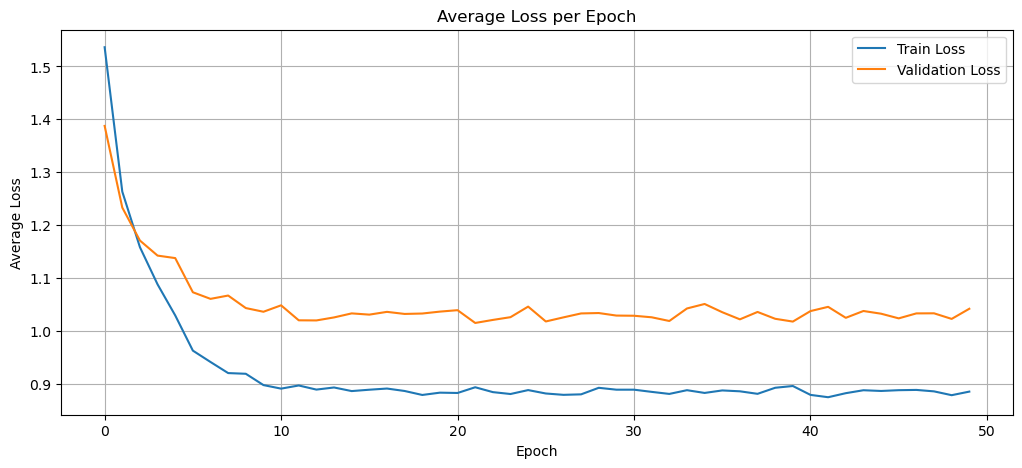

In [247]:
# Path to the CSV file
csv_file_path = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\training_metrics.csv'

# Load the metrics from the CSV file
metrics_df = pd.read_csv(csv_file_path)

# Plot Average Losses
plt.figure(figsize=(27, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(metrics_df['Epoch'], metrics_df['Average Train Loss'], label='Train Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Average Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)

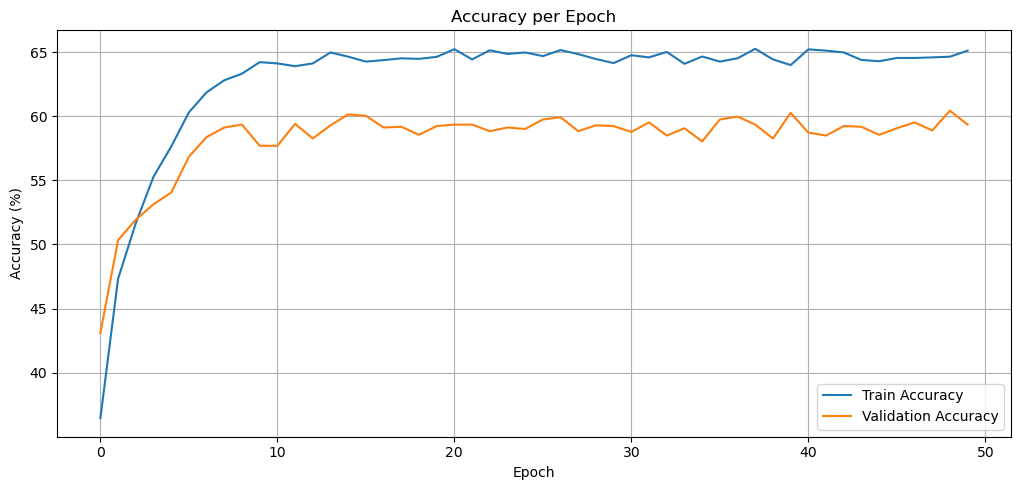

In [248]:
# Plot Accuracies
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

In [14]:
model = torch.load (r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\latest_checkpoint.pth")

C:\Users\vindu\AppData\Local\Temp\ipykernel_29072\228881138.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load (r"C:\Users\vindu\Documents\FYP_NEW\ML_mod

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate the model and generate confusion matrix
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.no_grad():  # Disable gradient computation
        for data in dataloader:
            inputs = data['data_sample'].float().to(device)
            inputs = inputs.permute(0, 3, 1, 2)  # Convert to (batch, channels, height, width)
            labels = data['lable'].to(device)
            
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return y_true, y_pred

# Generate predictions and true labels
y_true, y_pred = evaluate_model(net, dataloader_test, device)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class labels
class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


NameError: name 'net' is not defined

In [ ]:
import pandas as pd
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torchvision import models
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from typing_extensions import dataclass_transform
import random

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class SkinData:
  def __init__(self, root, transform = True, train = True):
      if train:
        data_folder = 'balanced_dataset/'

      else:
        data_folder = 'Validation_Image/'

      data_dirs = os.listdir(os.path.join(root,data_folder))
      self.data_files = []
      self.labels = []
      label = 0
      for dir in data_dirs:
        path_name = os.path.join(root,data_folder,dir)
        data_samples = [os.path.join(path_name, fname) for fname in os.listdir(path_name)]
        label_samples = label * np.ones(len(data_samples))
        print(dir)
        print(len(label_samples))
        self.data_files.extend(data_samples)
        self.labels.extend(label_samples)
        self.transform = transform

        label += 1

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, index):
    new_width = 256
    new_height = 256
    data_file = self.data_files[index]
    image = np.array(cv2.imread(data_file))
    label = np.array(self.labels[index])

    data_sample = cv2.resize(image, (new_width, new_height))
    resize_data = np.array(data_sample)

    if self.transform:
      data_sample = torch.from_numpy(data_sample)
      lable = torch.from_numpy(label)

    data_point = {'data_sample': data_sample, 'lable':lable}

    return data_point

In [ ]:
root = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer'
dataset = SkinData(root, transform=True, train= True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loder = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loder = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_dataset = SkinData(root, transform=True, train = False)

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

akiec
1244
bcc
1464
bkl
1044
df
1308
mel
1057
nv
1302
vasc
1350
akiec
16
bcc
26
bkl
55
df
6
mel
56
nv
335
vasc
7


In [ ]:
len(train_dataset)

7015

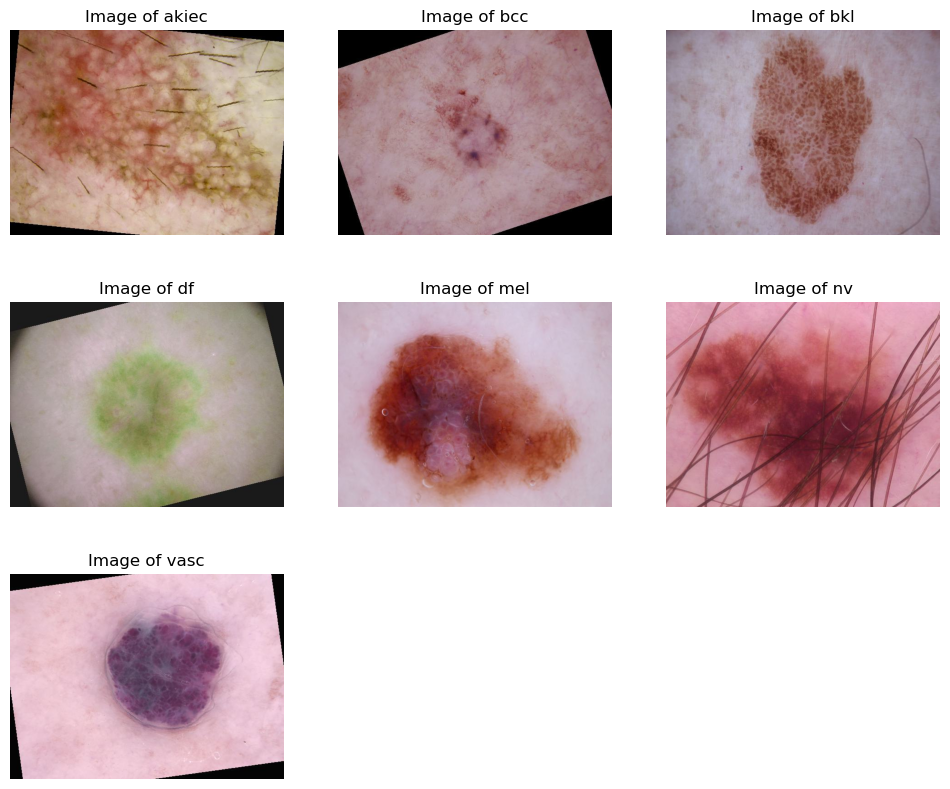

In [ ]:
# Data Visualization
# Define the directory path for the training images
train_images_dir = r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Balanced_dataset"

top_n = 20  # Variable for top-n random images to select from.
image_sample = []  # List containing array of images.
image_sample_category = []  # List containing image type

# Make sure train_images_dir is correctly defined before this loop
for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = []  # List of top n images from current sub-dir.

    # Ensure we handle cases where there are fewer than top_n images
    num_images = min(len(images_paths), top_n)

    # Appending up to top_n images from the current sub-dir
    for image_path in images_paths[:num_images]:
        current_dir_img_paths.append(image_path)

    # Select a random image from the current directory
    if current_dir_img_paths:
        selected_image = random.choice(current_dir_img_paths)  # Selecting random image from the list
        image = cv2.imread(selected_image)  # Reading the image

        if image is not None:
            image = image[:, :, ::-1]  # Converting BGR to RGB
            image_sample_category.append(sub_dir.name)  # Append image category (cancer type)
            image_sample.append(image)  # Append the image array to the list
        else:
            print(f"Warning: Could not read image {selected_image}")
    else:
        print(f"No images found in directory {sub_dir.name}")

# Plotting the selected random images
plt.figure(figsize=(12, 10))
for num in range(len(image_sample)):
    plt.subplot(3, 3, num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}")
    plt.imshow(image_sample[num])

plt.show()

tensor(0., dtype=torch.float64)


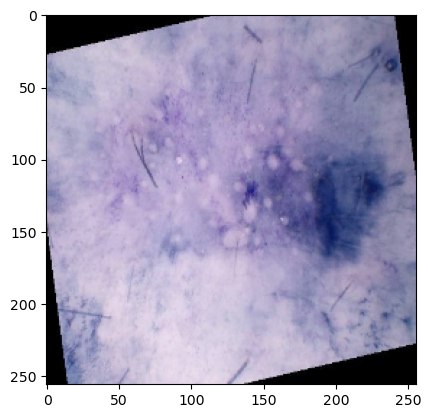

In [ ]:
plt.imshow(train_dataset[1000]['data_sample'])
print(train_dataset[1000]['lable'])

In [ ]:
train_dataset[1000]['data_sample'].shape

torch.Size([256, 256, 3])

In [ ]:
# Train Accuracy: 73.26%, Validation Accuracy: 64.56%
import torch
import torch.nn as nn

class ImprovedCNNNet(nn.Module):
    def __init__(self):
        super(ImprovedCNNNet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512
            
            nn.Flatten(),  # Flatten the 8x8x512 to a vector
            nn.Linear(8 * 8 * 512, 1024, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 128, bias=True),
            nn.ReLU(True),
            nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
# class ImprovedCNNNet(nn.Module):
#     def __init__(self):
#         super(ImprovedCNNNet, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512

#             nn.Flatten(),  # Flatten the 8x8x512 to a vector
#             nn.Linear(8 * 8 * 512, 1024, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),  # Dropout to reduce overfitting
#             nn.Linear(1024, 512, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Linear(512, 128, bias=True),
#             nn.ReLU(True),
#             nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x):
#         out = self.main(x)
#         return out

In [ ]:
# # Model definition (from previous artifact)
# class ResNetSkinCancer(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNetSkinCancer, self).__init__()
#         self.resnet = models.resnet50(pretrained=True)
#         for param in list(self.resnet.parameters())[:-30]:
#             param.requires_grad = False
#         num_features = self.resnet.fc.in_features
#         self.classifier = nn.Sequential(
#             nn.Linear(num_features, 2048),
#             nn.BatchNorm1d(2048),
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Linear(2048, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(True),
#             nn.Dropout(0.4),
#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(True),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(True),
#             nn.Dropout(0.2),
#             nn.Linear(256, num_classes),
#             nn.LogSoftmax(dim=1)
#         )
#         self.resnet.fc = self.classifier

#     def forward(self, x):
#         return self.resnet(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
net = ImprovedCNNNet().to(device)

In [ ]:
print(torch.cuda.get_device_name(0))  # To check your GPU device name
print(torch.cuda.is_available())  # To confirm GPU is available

NVIDIA GeForce RTX 3050 Laptop GPU
True


In [ ]:
import torch.optim as optim
# Print the network architecture
print(net)
# Optimizer: Adamax
optimizer = optim.Adamax(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Loss function
criterion = nn.CrossEntropyLoss()

ImprovedCNNNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(2

In [ ]:
len(dataloader_train)

439

In [ ]:
# Lists to store average losses and accuracies per epoch
avg_train_loss_list = []
avg_val_loss_list = []
train_acc_list = []
val_acc_list = []

# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
# def load_checkpoint(model, optimizer, scheduler, filename='latest_checkpoint.pth'):
#     if os.path.exists(filename):
#         print(f"Loading checkpoint '{filename}'")
#         checkpoint = torch.load(filename)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#         start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
#         print(f"Resuming from epoch {start_epoch}")
#     else:
#         print(f"No checkpoint found at '{filename}', starting from scratch")
#         start_epoch = 0  # Start from scratch if no checkpoint
#     return start_epoch

# # Load checkpoint if exists
# checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
# start_epoch = load_checkpoint(net, optimizer, scheduler, filename=checkpoint_path)

# Training Loop
for epoch in range(start_epoch, 50):  # Now starts from the saved epoch
    accuracy = 0
    val_accuracy = 0
    running_loss = 0.0
    val_running_loss = 0.0
    num_batches_train = len(dataloader_train)
    num_batches_val = len(dataloader_val)

    # Training loop
    for i, data in enumerate(dataloader_train, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        loss = criterion(prediction, encoded_labels.float())
        running_loss += loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        accuracy += sum(predicted_class == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('epoch:', epoch, 'loss:', loss.item())

    avg_train_loss = running_loss / num_batches_train
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    for i, data in enumerate(dataloader_val, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        val_loss = criterion(prediction, encoded_labels.float())
        val_running_loss += val_loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        val_accuracy += sum(predicted_class == labels)

    avg_val_loss = val_running_loss / num_batches_val
    avg_val_loss_list.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

    accuracy = accuracy.cpu().numpy()
    train_acc_list.append(accuracy / train_dataset.__len__() * 100)
    val_accuracy = val_accuracy.cpu().numpy()
    val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

    scheduler.step()

    # Save model checkpoint after each epoch
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss.item(),
}, os.path.join(save_dir, 'latest_checkpoint.pth'), _use_new_zipfile_serialization=False)


    print(f'Model saved after epoch {epoch}')
    print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    # After each epoch, save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': [epoch],
        'Train Accuracy': [train_acc_list[-1]],
        'Validation Accuracy': [val_acc_list[-1]],
        'Average Train Loss': [avg_train_loss],
        'Average Validation Loss': [avg_val_loss]
    })

    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
    print("Epoch metrics saved to training_metrics.csv")

No checkpoint found at 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\latest_checkpoint.pth', starting from scratch
epoch: 0 loss: 1.934117078781128
epoch: 0 loss: 1.961171269416809
epoch: 0 loss: 1.8168014287948608
epoch: 0 loss: 1.5640227794647217
epoch: 0 loss: 1.6484489440917969
epoch: 0 loss: 1.6022241115570068
epoch: 0 loss: 1.3957552909851074
epoch: 0 loss: 1.4415733814239502
epoch: 0 loss: 1.7651889324188232
Epoch 0: Train Accuracy: 36.61%, Validation Accuracy: 42.70%
Model saved after epoch 0
Average Train Loss: 1.5370, Average Validation Loss: 1.3893
Epoch metrics saved to training_metrics.csv
epoch: 1 loss: 1.1107375621795654
epoch: 1 loss: 1.5379799604415894
epoch: 1 loss: 1.5079741477966309
epoch: 1 loss: 1.3778566122055054


KeyboardInterrupt: 

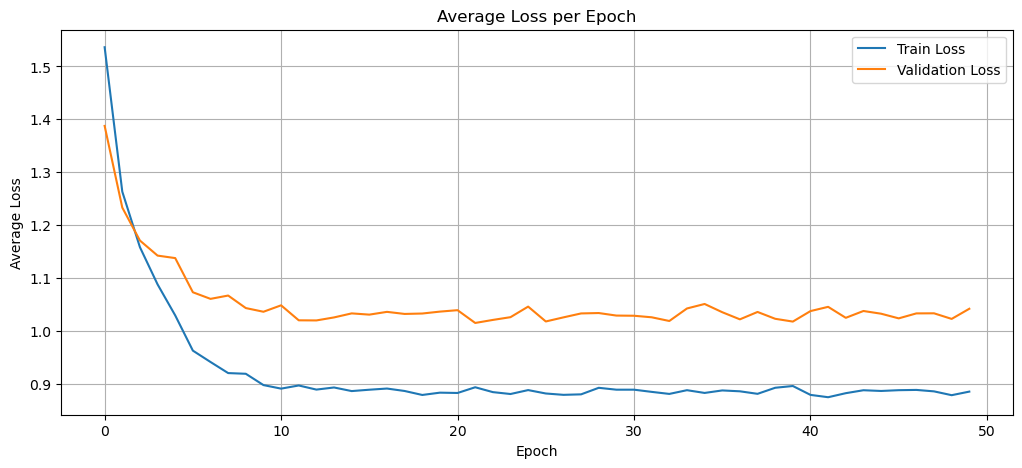

In [ ]:
# Path to the CSV file
csv_file_path = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\training_metrics.csv'

# Load the metrics from the CSV file
metrics_df = pd.read_csv(csv_file_path)

# Plot Average Losses
plt.figure(figsize=(27, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(metrics_df['Epoch'], metrics_df['Average Train Loss'], label='Train Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Average Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)

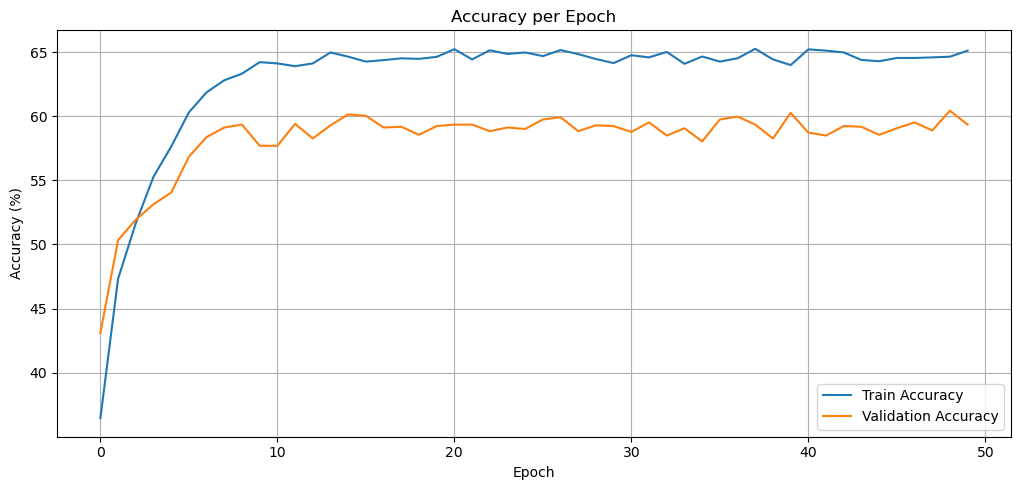

In [ ]:
# Plot Accuracies
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

In [7]:
model = torch.load(r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\latest_checkpoint.pth")

C:\Users\vindu\AppData\Local\Temp\ipykernel_18532\1337794407.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r"C:\Users\vindu\Documents\FYP_NEW\ML_mod

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [33]:
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, scheduler, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer, scheduler, filename=checkpoint_path)

Loading checkpoint 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\model_01\latest_checkpoint.pth'


C:\Users\vindu\AppData\Local\Temp\ipykernel_18532\2439282276.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory